In [151]:
#@title Settings { run: "auto" }

# SETTINGS
proj_width = 5760 #@param {type:"integer"}
proj_height = 1080 #@param {type:"integer"}

bucket = 'lightleaks'
bucket_folder = "todaysart" #@param ["music_center", "todaysart"] {allow-input: true}

promap_name = 'promap-301'
# promap_name = 'promap-51'

LOCAL = True

if LOCAL:
    data_dir = '/home/jovyan/SharedData'
else:
    data_dir = '/tmp/data/'+bucket_folder

In [56]:
# !sudo apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
# !sudo apt-get install -y libturbojpeg  libxrender-dev
# !pip install jpeg4py msgpack numpy-indexed

# !rm -rf utils
# !git clone https://github.com/kylemcdonald/python-utils utils
import sys

# Utils is added at this path in docker image:
sys.path.append('/home/jovyan/')

import cv2
from utils.imutil import *
from utils.progress import *
# from utils.show_array import *
from matplotlib import pyplot as plt
from itertools import product
import glob 
from scipy import ndimage
from multiprocessing import Pool, cpu_count
from numba import jit


# !pip install mpld3
# import matplotlib.pyplot as plt, mpld3
%matplotlib inline

# mpld3.

In [152]:
import re
folders = sorted([f for f in os.listdir(data_dir) if re.match(r'^scan-', f)])

# folders = [
# #     'scan-2008',
# #     'scan-2013',
# #     'scan-2017',
# #     'scan-2021',
# #     'scan-2025',
# #     'scan-2030',
# #     'scan-2041',
# #     'scan-2046',
# #     'scan-2326',
#     'scan-2344',
# ]

def overflow_fix(proMap):
    proMap[(proMap[:,0] >= proj_width) | (proMap[:,1] >= proj_height)] = [0,0]

# rows, cols = camHeight, camWidth
# confidence.shape: rows, cols (float)
# proMap.shape: rows, cols, 2 (int)
# xyzMap.shape: rows, cols, 3 (float)
# cam_index: int
def pack_maps(confidence, proMap, xyzMap, cam_index):
    """ Pack camera confidence, cam projector map and camera xyz map """
    # prepare confidenceFlat
    confidenceFlat = confidence.reshape(-1,1)
    
    # prepare proMapFlat
    proMapFlat = proMap.reshape(( -1, 2))
    overflow_fix(proMapFlat)
    proMapFlat = np.ravel_multi_index(proMapFlat.transpose()[::-1], (proj_height, proj_width)).reshape(-1,1)
    
    # prepare xyzMapFlat
    scale = len(proMap) / len(xyzMap)
    xyzMap = upsample(xyzMap, scale=scale)
    xyzMapFlat = xyzMap.reshape(-1, 3)
    
    # Pack camera index into array
    camIndexFlat = np.full((xyzMapFlat.shape[0],1), cam_index)
        
    # stack and return everything in shape: (rows x cols), 6
    return np.hstack((confidenceFlat, proMapFlat, xyzMapFlat, camIndexFlat))


    
def dedupe(packed):
    # get indices sorted by confidence, use ::-1 to put max confidence first
    packedSortedIndices = packed[:,0].argsort()[::-1]
    packedSorted = packed[packedSortedIndices]
    # get unique packedSorted indices
    _, indices = np.unique(packedSorted.transpose()[1], return_index=True)
    return packedSorted[indices]

deduped = None
for i, folder in enumerate(folders):
    print(folder+'/'+promap_name)
    confidence = imread(os.path.join(data_dir, folder, promap_name, 'camConfidence.exr'))
    proMap = np.load(os.path.join(data_dir, folder, promap_name,'camBinary.npy'))
    xyzMap = imread(os.path.join(data_dir, folder,'xyzMap.exr'))
    
    assert len(confidence) > 0
    assert len(proMap) > 0
    assert len(xyzMap) > 0
    
    packed = pack_maps(confidence, proMap, xyzMap, i)
    print('packed before:', packed.shape)
    if deduped is not None:
#         print('deduped before:', deduped.shape)
        packed = np.vstack((packed, deduped))
#         print('packed after:', packed.shape)
    deduped = dedupe(packed)
    print('deduped after:', deduped.shape)

print('hallelujah')

scan-2008/promap-301
packed before: (17915904, 6)
deduped after: (1704023, 6)
scan-2013/promap-301
packed before: (17915904, 6)
deduped after: (2466031, 6)
scan-2017/promap-301
packed before: (17915904, 6)
deduped after: (3023592, 6)
scan-2021/promap-301
packed before: (17915904, 6)
deduped after: (3400749, 6)
scan-2025/promap-301
packed before: (17915904, 6)
deduped after: (3747592, 6)
scan-2030/promap-301
packed before: (17915904, 6)
deduped after: (4017797, 6)
scan-2041/promap-301
packed before: (17915904, 6)
deduped after: (4244581, 6)
scan-2046/promap-301
packed before: (17915904, 6)
deduped after: (4489002, 6)
scan-2326/promap-301
packed before: (17915904, 6)
deduped after: (4605825, 6)
scan-2344/promap-301
packed before: (17915904, 6)
deduped after: (4689372, 6)
hallelujah


proXyzMap


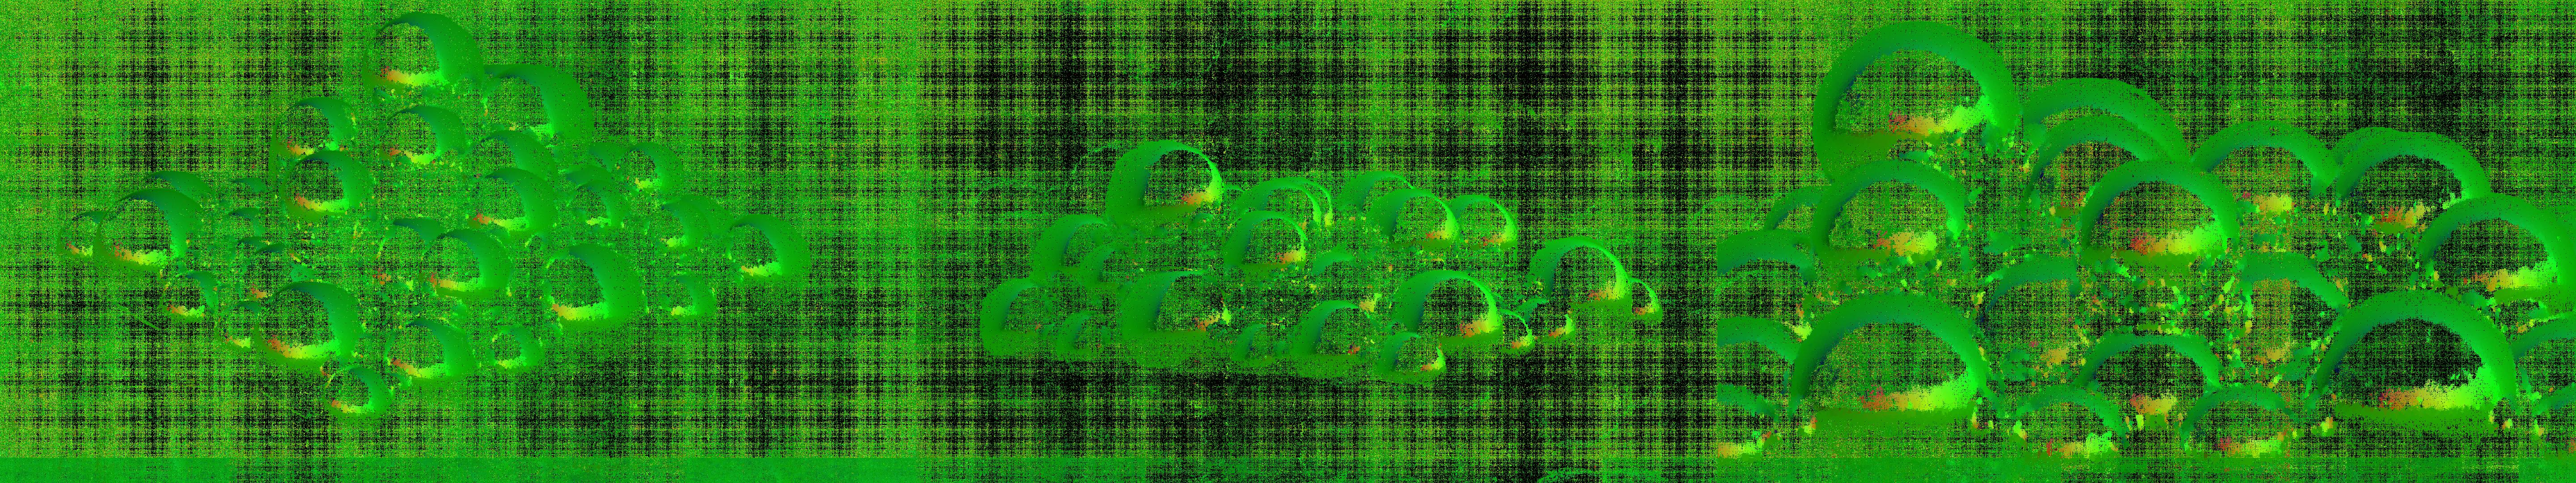

ProConfidence


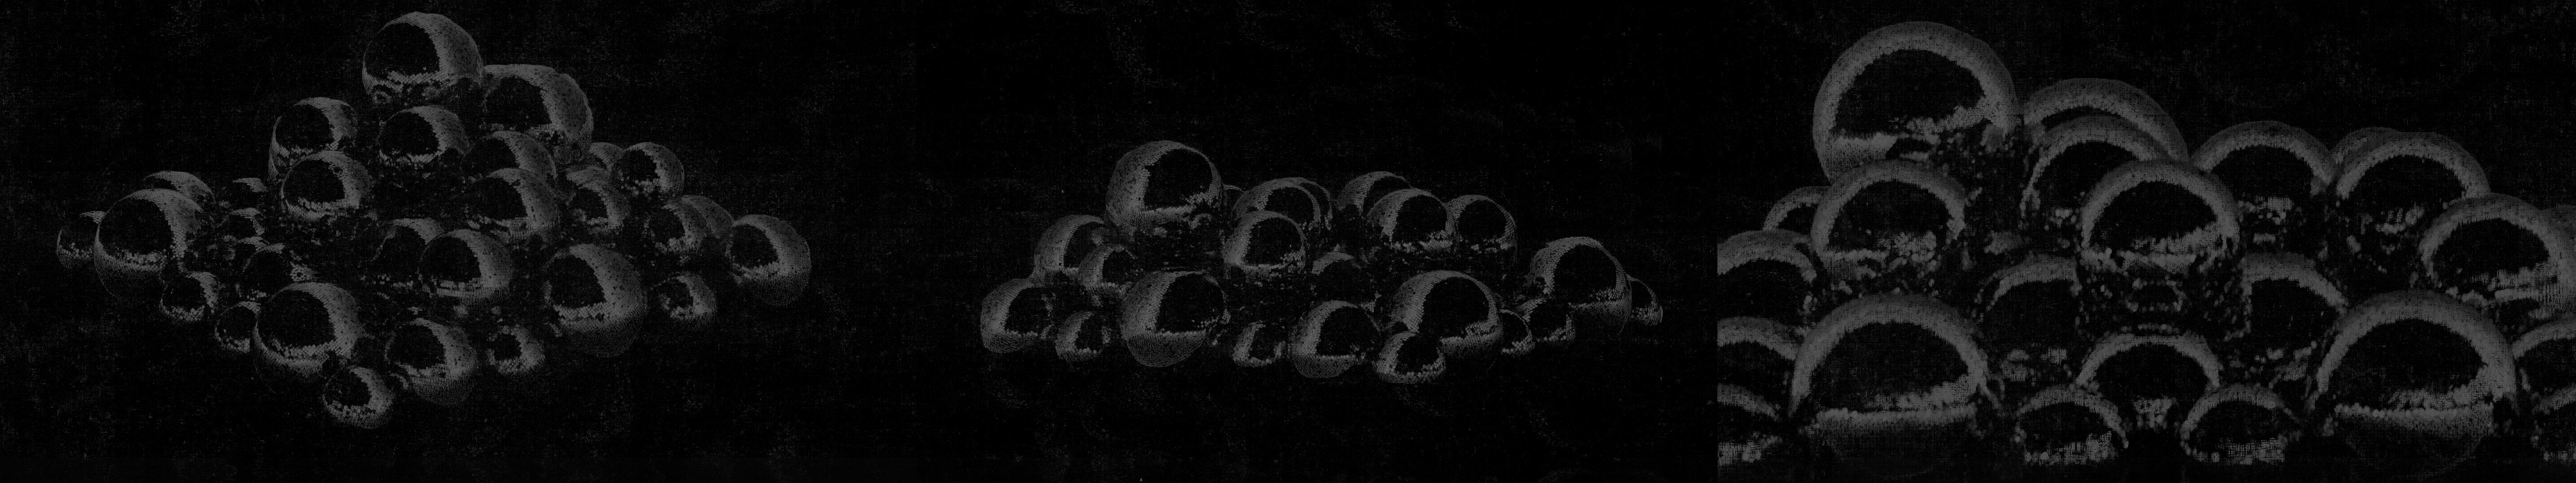

Cam index map


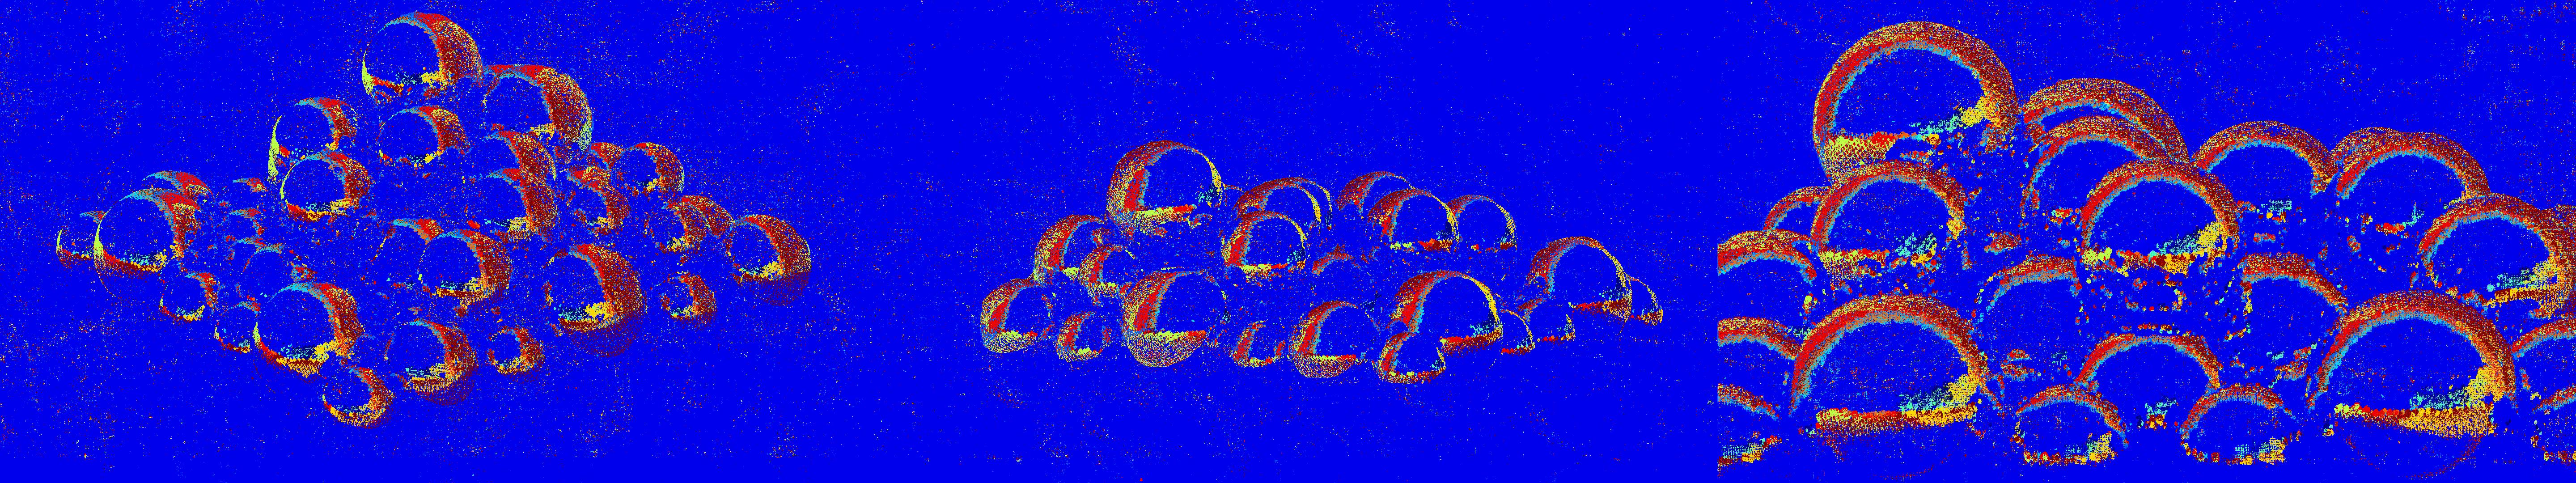

In [153]:
import matplotlib.pyplot as plt

def unpack_maps(packed):
    """ Unpack projector xyz map and projector confidence """
    proXyzMap = np.zeros((proj_height, proj_width, 3))
    proConfidence = np.zeros((proj_height, proj_width, 1))
    camIndex = np.zeros((proj_height, proj_width, 1))
    
    # assign xyzMap values use proMapFlat indices
    proMapFlat = packed[:,1].astype(np.int32)
    proXyzMap.reshape(-1, 3)[proMapFlat] = packed[:,2:5]
    proConfidence.reshape(-1)[proMapFlat] = packed[:,0]
    camIndex.reshape(-1)[proMapFlat] = packed[:,5]
    
    return proXyzMap, proConfidence, camIndex

proXyzMap, proConfidence, camIndexMap = unpack_maps(deduped)
print("proXyzMap")
imshow(proXyzMap*255, fmt='jpg')
print("ProConfidence")
imshow(proConfidence*255, fmt='jpg')

print("Cam index map")
camIndexMapColored = np.copy(camIndexMap)
camIndexMapColored[ proConfidence < 0.1 ] = -1
camIndexMapColored = camIndexMapColored * 255 /  camIndexMap.max()
camIndexMapColored = cv2.applyColorMap(camIndexMapColored.astype(np.uint8), cv2.COLORMAP_JET)
imshow(camIndexMapColored, fmt='jpg')


# print(u, c)


In [154]:
debug_out_path = '../SharedData/BuildXYZ-%s/' % promap_name
if not os.path.exists(debug_out_path):
    os.makedirs(debug_out_path)


projMask = imread(os.path.join(data_dir, 'mask-0.png')).mean(axis=2) / 255
proConfidenceMasked = proConfidence * projMask[:,:,np.newaxis]
imwrite(debug_out_path+'confidenceMap-0.exr', proConfidenceMasked.astype(np.float32))
imwrite(debug_out_path+'xyzMap-0.exr', proXyzMap.astype(np.float32))
imwrite(debug_out_path+'camIndexMap.png', camIndexMap)
imwrite(debug_out_path+'camIndexMapColored.png', camIndexMapColored)

with open(debug_out_path+"BuildXYZOutput.txt", "w") as text_file:
    def t(text):
        text_file.write("%s\n" % text)
        print(text)
        
    t("Scans used:")
    for s in folders:
        t("\t%s" % s)
    t("\nProMap folder used: %s" % promap_name)
    t("Resolution: %ix%i" % (proj_width, proj_height))
    
    threshold = 0.1
    t("\nCoverage (threshold %.2f):" % threshold)
    masked_camIndexMap = np.copy(camIndexMap)
    masked_camIndexMap[ proConfidence < threshold ] = -1
    u, c = np.unique(masked_camIndexMap, return_counts=True)
    for _u,_c in zip(u,c):
        if _u != -1:
            t("\tScan %i (%s): %.2f%% (%i)" % (_u, folders[int(_u)], 100*_c / sum(c), _c))
        else:
            t("\tNo scan: %.2f%% (%i)" % (100*_c / sum(c), _c))
    


# imwrite('../SharedData/confidenceMap-0-'+folders[0]+'.exr', proConfidenceMasked.astype(np.float32))
# imwrite('../SharedData/xyzMap-0-'+folders[0]+'.exr', proXyzMap.astype(np.float32))

Scans used:
	scan-2008
	scan-2013
	scan-2017
	scan-2021
	scan-2025
	scan-2030
	scan-2041
	scan-2046
	scan-2326
	scan-2344

ProMap folder used: promap-301
Resolution: 5760x1080

Coverage (threshold 0.10):
	No scan: 80.85% (5029374)
	Scan 0 (scan-2008): 4.52% (281398)
	Scan 1 (scan-2013): 4.01% (249475)
	Scan 2 (scan-2017): 1.42% (88370)
	Scan 3 (scan-2021): 1.23% (76744)
	Scan 4 (scan-2025): 2.56% (159306)
	Scan 5 (scan-2030): 0.34% (20874)
	Scan 6 (scan-2041): 1.29% (80397)
	Scan 7 (scan-2046): 2.85% (177050)
	Scan 8 (scan-2326): 0.37% (23019)
	Scan 9 (scan-2344): 0.56% (34793)
